##### 0.1. We import all the needed libraries.

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import fitter as ft
import numpy as np
import joblib
import dtale
import os

##### 0.2. We will set some global settings for some modules.

In [2]:
%matplotlib ipympl
sns.set_style('white')
pd.options.mode.chained_assignment = None

##### 0.3. import the data file as a pandas dataframe

In [3]:
# importing data from file
data_path = os.path.join(os.getcwd(), 'Data\\banking_customer_info.csv')
customer_data_raw = pd.read_csv(data_path)

# setting ID column as index and sorting the data by ID
customer_data_raw.sort_values(by=['ID'], inplace=True)

### 1. Managing the outliers

##### 1.1. Analyzing the data

→ Dtale tool:

In [4]:
# for further optional analysis of the initial data
dtale.show(customer_data_raw)

Histogram of all the features (to get a visualization of their distribution):

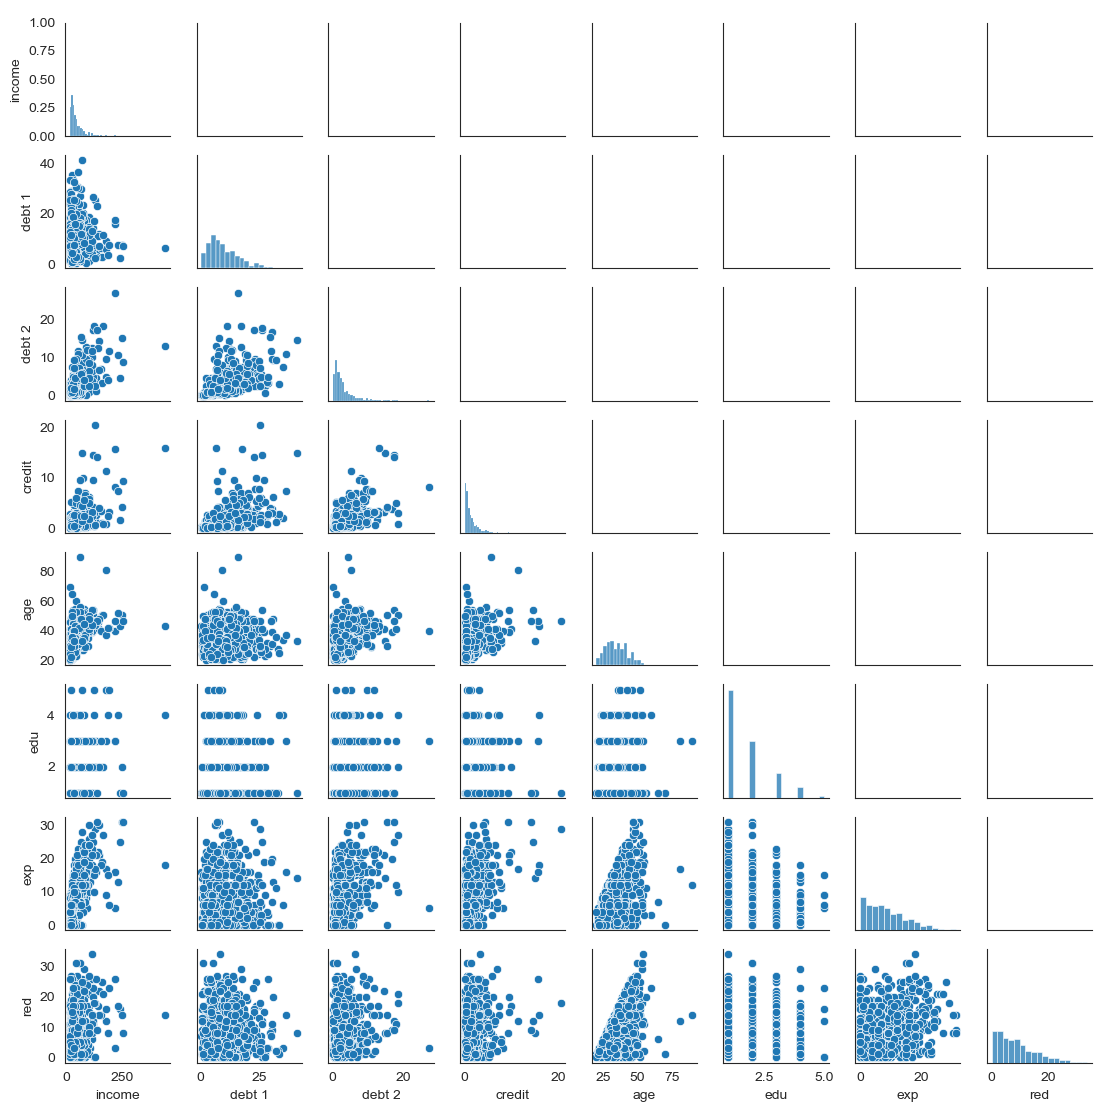

In [5]:
# eliminating ID and loyalty columns from the plot
cols_to_plot = customer_data_raw.columns[1:-1]

# creating the figure to see relationship between differect columns and each feature's distribution
fgrid = sns.PairGrid(customer_data_raw[cols_to_plot], height=1.4)
fgrid.map_diag(sns.histplot)
fgrid.map_lower(sns.scatterplot)

plt.show()

##### 1.2. Managing outliers of normally distributed features: 'debt1' and 'age' using z-score

In [6]:
# making a subset of the dataframe containing the normally distributed columns
normal_data_cols = customer_data_raw[['debt 1', 'age']]

# calculating z-score of the columns
z_score = np.abs(normal_data_cols.apply(stats.zscore, nan_policy='omit'))

# detecting outliers and their index in the dataset
debt1_outliers = np.where(z_score['debt 1'] > 3)
age_outliers = np.where(z_score['age'] > 3)

# setting all the outliers as missing values to be dealt with in later steps
customer_data_raw['debt 1'].loc[debt1_outliers] = np.nan
customer_data_raw['age'].loc[age_outliers] = np.nan

print('Outlier IDs:')
print('debt 1:\t' + str(*debt1_outliers))
print('age:\t' + str(*age_outliers))

Outlier IDs:
debt 1:	[122 373 381 492 583 584 654]
age:	[  0  10 206 493]


##### 1.3. Managing outliers of other features using IQR

In [7]:
# creating a subset of the data that contains non-normal features
non_normal_data = customer_data_raw[['income', 'debt 2', 'credit', 'exp', 'red']]

# finding the IQR for each feature
data_1st = non_normal_data.quantile(q=0.25)
data_3rd = non_normal_data.quantile(q=0.75)
data_IQR = data_3rd - data_1st

# finding the boundaries for the values of each feature
upper_bounds = data_3rd + 2.5 * data_IQR
lower_bounds = data_1st - 2.5 * data_IQR

# detecting outliers for each column
income_outliers = np.where((non_normal_data['income'] > upper_bounds['income'])
                        | (non_normal_data['income'] < lower_bounds['income']))
debt2_outliers = np.where((non_normal_data['debt 2'] > upper_bounds['debt 2'])
                        | (non_normal_data['debt 2'] < lower_bounds['debt 2']))
credit_outliers = np.where((non_normal_data['credit'] > upper_bounds['credit'])
                        | (non_normal_data['credit'] < lower_bounds['credit']))
exp_outliers = np.where((non_normal_data['exp'] > upper_bounds['exp'])
                        | (non_normal_data['exp'] < lower_bounds['exp']))
red_outliers = np.where((non_normal_data['red'] > upper_bounds['red'])
                        | (non_normal_data['red'] < lower_bounds['red']))

# setting outliers as missing values to be dealt with later
customer_data_raw['income'].loc[income_outliers] = np.nan
customer_data_raw['debt 2'].loc[debt2_outliers] = np.nan
customer_data_raw['credit'].loc[credit_outliers] = np.nan
customer_data_raw['exp'].loc[exp_outliers] = np.nan
customer_data_raw['red'].loc[red_outliers] = np.nan

print('Outlier IDs:')
print('income:\t' + str(*income_outliers))
print('debt 2:\t' + str(*debt2_outliers))
print('credit:\t' + str(*credit_outliers))
print('exp:\t' + str(*exp_outliers))
print('red:\t' + str(*red_outliers))

Outlier IDs:
income:	[  0 142 217 250 292 343 410 437 444 450 456 466 478 502 528 557 622 625
 632 691]
debt 2:	[  6 210 217 223 250 325 326 343 373 403 419 442 444 478 502 528 542 547
 549 557 572 583 632 666]
credit:	[  0  35  65 104 165 243 300 310 325 343 354 373 381 393 429 430 444 466
 487 557 564 583 599 601 631 632 691]
exp:	[]
red:	[]


<span style="color:red">-- NOTE:</span> the column 'edu' was skipped since it is a ordinal categorical data
<hline>
### 2. Managing missing values

##### 2.1. Eliminating the rows where all values are missing and columns with more than 50% missing values

In [8]:
customer_data = customer_data_raw.dropna(axis=0, how='all').dropna(axis=1, thresh=350)

<span style="color:red">-- NOTE:</span> none of the rows or columns are deleted in this section.

##### 2.2. Analysing missing values of each feature

In [9]:
print('The number of missing values in each feature:\n' + customer_data.isna().sum().to_string())

The number of missing values in each feature:
ID          0
income     57
debt 1      7
debt 2     62
credit     27
age        23
edu        20
exp         0
red         0
loyalty     0


We have four levels of missing values:
- <p><b>High count:</b> income, debt 2
- <p><b>Medium count:</b> credit, age, edu
- <p><b>Low count:</b> debt 1
- <p><b>No Missings:</b> exp, red, loyalty

##### 2.3. Filling features with low count of missing values
-- For these, we will use the constant value of the median of the feature

In [10]:
# creating a subset of the data that contains low count features
low_count_columns = customer_data['debt 1']

# finding the IQR for each feature
low_count_median = low_count_columns.quantile(q=0.5)

# filling the missing cells with the median of the column
customer_data['debt 1'] = low_count_columns.fillna(value=low_count_median)

##### 2.4. Filling medium count columns
-- Since the number of missing values are a bit higher in these columns, we will fill them with random values.

-- Also, for the edu column which is a nominal column, we fill the missing values with current distribution of the column

In [11]:
dists = ['chi2', 'gamma', 'norm', 'lognorm', 'expon', 'beta', 'uniform', 'burr']

# array of credit column values
credit = customer_data['credit'].dropna(how='any').values
# make a new instance of fitter
credit_fit = ft.Fitter(credit, distributions=dists)
credit_fit.fit()
credit_fit.get_best(method='sumsquare_error')

2022-08-31 12:52:01,868 - INFO     - Fitted norm distribution with error=3.066939122343907)
2022-08-31 12:52:01,878 - INFO     - Fitted uniform distribution with error=4.825184132972533)
2022-08-31 12:52:01,892 - INFO     - Fitted expon distribution with error=0.6736051172972477)
2022-08-31 12:52:02,225 - INFO     - Fitted chi2 distribution with error=0.6466066438978377)
2022-08-31 12:52:02,333 - INFO     - Fitted gamma distribution with error=0.6504375241921783)
2022-08-31 12:52:02,410 - INFO     - Fitted lognorm distribution with error=0.538051042737615)
2022-08-31 12:52:02,593 - INFO     - Fitted beta distribution with error=1.3180858969000506)
2022-08-31 12:52:02,771 - INFO     - Fitted burr distribution with error=0.7233222124243934)


{'lognorm': {'s': 1.00051325125228,
  'loc': -0.047663022025216495,
  'scale': 0.8227679035570872}}

In [12]:
# getting all the parameters of the best fitted distribution (lognormal)
credit_fit_params = credit_fit.fitted_param['lognorm']
credit_fit_std = float(credit_fit_params[0])
credit_fit_mean = float(credit_fit_params[1])
credit_fit_size = float(credit_fit_params[2])

# filling the missing values of credit with random numbers
customer_data['credit'].fillna(value=np.random.lognormal(mean=credit_fit_mean, sigma=credit_fit_std), inplace=True)

print('The number of missing values in each feature:\n' + customer_data.isna().sum().to_string())

The number of missing values in each feature:
ID          0
income     57
debt 1      0
debt 2     62
credit      0
age        23
edu        20
exp         0
red         0
loyalty     0


In [13]:
# array of age column values
age = customer_data['age'].dropna(how='any').values
# make a new instance of fitter
age_fit = ft.Fitter(age, distributions=dists)
age_fit.fit()
age_fit.get_best(method='sumsquare_error')

2022-08-31 12:52:03,143 - INFO     - Fitted norm distribution with error=0.14564695428574595)
2022-08-31 12:52:03,149 - INFO     - Fitted uniform distribution with error=0.16717944424201636)
2022-08-31 12:52:03,151 - INFO     - Fitted expon distribution with error=0.17225100606930954)
2022-08-31 12:52:03,598 - INFO     - Fitted beta distribution with error=0.1425806527505055)
2022-08-31 12:52:03,741 - INFO     - Fitted gamma distribution with error=0.1438661222204122)
2022-08-31 12:52:04,180 - INFO     - Fitted chi2 distribution with error=0.5366386921453933)
2022-08-31 12:52:04,197 - INFO     - Fitted lognorm distribution with error=0.14421571031207978)
2022-08-31 12:52:04,490 - INFO     - Fitted burr distribution with error=0.145766026433259)


{'beta': {'a': 1.9406052654371353,
  'b': 3.5572778057778005,
  'loc': 19.650140560291455,
  'scale': 42.80174551416858}}

In [14]:
# getting all the parameters of the best fitted distribution (beta)
age_fit_params = age_fit.fitted_param['beta']
age_fit_a = float(age_fit_params[0])
age_fit_b = float(age_fit_params[1])

# filling the missing values of credit with random numbers
customer_data['age'].fillna(value=np.random.beta(a=age_fit_a, b=age_fit_b), inplace=True)

print('The number of missing values in each feature:\n' + customer_data.isna().sum().to_string())

The number of missing values in each feature:
ID          0
income     57
debt 1      0
debt 2     62
credit      0
age         0
edu        20
exp         0
red         0
loyalty     0


In [15]:
# array of edu column values
edu = customer_data['edu'].dropna(how='any').values
# make a new instance of fitter
edu_fit = ft.Fitter(edu, distributions=dists)
edu_fit.fit()
edu_fit.get_best(method='sumsquare_error')

2022-08-31 12:52:04,780 - INFO     - Fitted norm distribution with error=230.36539645911597)
2022-08-31 12:52:04,792 - INFO     - Fitted expon distribution with error=215.17142483259218)
2022-08-31 12:52:04,800 - INFO     - Fitted uniform distribution with error=233.00443339100306)
2022-08-31 12:52:06,022 - INFO     - Fitted gamma distribution with error=171.4791242008192)
2022-08-31 12:52:06,124 - INFO     - Fitted chi2 distribution with error=199.92056008966992)
2022-08-31 12:52:06,457 - INFO     - Fitted beta distribution with error=191.56030378803757)
2022-08-31 12:52:06,476 - INFO     - Fitted lognorm distribution with error=182.9622631965463)
2022-08-31 12:52:06,752 - INFO     - Fitted burr distribution with error=237.40999277972537)


{'gamma': {'a': 0.6669153882597822,
  'loc': 0.9999999999999999,
  'scale': 0.5750316055832845}}

In [16]:
# getting all the parameters of the best fitted distribution (beta)
edu_fit_params = edu_fit.fitted_param['gamma']
edu_fit_shape = float(edu_fit_params[0])
edu_fit_scale = float(edu_fit_params[2])

# filling the missing values of credit with random numbers
customer_data['edu'].fillna(value=np.random.gamma(shape=edu_fit_shape, scale=edu_fit_scale), inplace=True)

print('The number of missing values in each feature:\n' + customer_data.isna().sum().to_string())

The number of missing values in each feature:
ID          0
income     57
debt 1      0
debt 2     62
credit      0
age         0
edu         0
exp         0
red         0
loyalty     0


##### 2.5. Filling high count columns
-- The remaining features have a high number of missing values so we are going to use KNNImputer to fill the missing cells.

In [17]:
# initializing the sk-learn KNN imputer model
missing_imputer = KNNImputer(n_neighbors=4, weights='distance')

customer_data_array = customer_data.to_numpy()

# filling the missing values
customer_data_array = missing_imputer.fit_transform(customer_data)

# replacing the columns with the new ones
customer_data['income'] = customer_data_array[:,1]
customer_data['debt 2'] = customer_data_array[:,3]

print('The number of missing values in each feature:\n' + customer_data.isna().sum().to_string())

The number of missing values in each feature:
ID         0
income     0
debt 1     0
debt 2     0
credit     0
age        0
edu        0
exp        0
red        0
loyalty    0


### 3. Feature Selection
<span style="color:red">-- NOTE:</span> This step is unnecessary since the dimensionality of the dataset is not an issue. This stage is done for educational purposes.

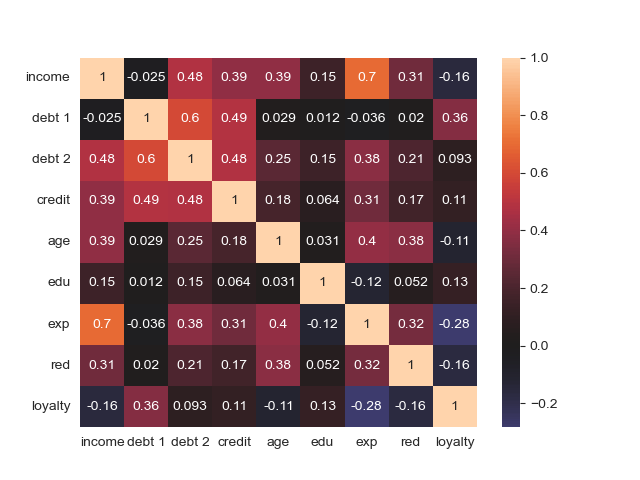

In [18]:
# plotting the correlation matrix
plt.figure()
features = ['income', 'debt 1', 'debt 2', 'credit', 'age', 'edu', 'exp', 'red', 'loyalty']
sns.heatmap(customer_data[features].corr(), center=0.0, annot=True, cmap="icefire")
plt.show()


-- From this figure, we can see that <b>income</b> and <b>work experience</b> have a high correlation. Since <b>work experience</b> has a higher correlation to the dependant variable, we will eliminate <b>income</b> from our dataset

-- We can also see that <b>debt 1</b> and <b>debt 2</b> are highly correlated. Since <b>debt 1</b> has a higher correlation to the dependant variable, we will eliminate <b>debt 2</b> from our dataset

In [19]:
# getting rid of columns that are dependant on other columns
customer_data.drop(columns=['income', 'debt 2'], inplace=True)

### 4. Normalization

-- In this section we rescale all the columns to be between zero and one and since the outliers have been managed, we will use min/max scalers to do so.

In [20]:
# initializing the sklearn minmax scaler
data_scaler = MinMaxScaler()

customer_data_array = customer_data.iloc[:, 1:-1].to_numpy()

# scaling all the columns from 0 to 1 and applying the new values to the dataset
customer_data_rescaled = data_scaler.fit_transform(customer_data_array)
customer_data['debt 1'] = customer_data_rescaled[:, 0]
customer_data['credit'] = customer_data_rescaled[:, 1]
customer_data['age'] = customer_data_rescaled[:, 2]
customer_data['edu'] = customer_data_rescaled[:, 3]
customer_data['exp'] = customer_data_rescaled[:, 4]
customer_data['red'] = customer_data_rescaled[:, 5]

# saving the scaler model for later use
joblib.dump(data_scaler, 'Models\\data_scaler.gz')

['Models\\data_scaler.gz']

### 5. Saving the processed dataset

-- The result is saved to 'processed_customer_data.csv' and is shown using the dtale data analyzation tool.

In [21]:
# setting the ID column as the index of the dataframe
# customer_data.set_index('ID', inplace=True)

customer_data.to_csv('Data/processed_customer_data.csv', index=False)

dtale.show(customer_data)